In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch

import time
from typing import Generator
from pathlib import Path
import re

In [2]:
DATASET_PATH = Path("/kaggle/input/imdb-50k-movie-reviews-test-your-bert")


class IMDBMovieReview:
    """Class implements all the dataset loading, handling and metrics."""
    def __init__(self) -> None:
        
        self.dataframe = pd.read_csv(
            filepath_or_buffer=DATASET_PATH / "train.csv",
            encoding="utf-8"
        )

    def __iter__(self) -> Generator[str, str, None]:
        for i in range(10):
            yield self.dataframe["text"].loc[i]

    def refine_structure(self) -> str:
        """Focuses the entire dataframe to only the text removing other cols."""
        if "sentiment" in self.dataframe.columns:
            self.dataframe = self.dataframe.drop(["sentiment"], axis=1)
        self.dataset_string = "\n".join(self.dataframe["text"])
        
        # Cleaning up the string
        self.dataset_string = re.sub(r'[^\x00-\x7F]+', " ", self.dataset_string)
        self.dataset_string = re.sub(r'[\U00010000-\U0010ffff]+', " ", self.dataset_string)
        self.dataset_string = re.sub(r'[\x08\x10#\$%&\*\+<=>@\[\\\]\^_`\{\|\}~]', " ", self.dataset_string)
        
        # Generating the vocabulary for the dataset string.
        self.vocab = sorted(list(set(self.dataset_string)))

        return self.dataset_string
    
    def datastring_metrics(self) -> None:
        """Provides metrics for the dataset string."""

        print(f"Length of the Dataset: {len(self.dataset_string)}\n")
        print(f"First 1000 Chars:\n{self.dataset_string[:1000]}\n")
        print(f"Vocabulary Size: {len(self.vocab)}\n")
        print(f"Vocabulary:\n{''.join(self.vocab)}")

In [3]:
class SelfAttentionHead(torch.nn.Module):
    """Class implements a single self-attention head."""
    def __init__(self, head_size: int, input_features: int, block_size: int, dropout_rate: float = 0.2):
        super().__init__()

        # Attention Matrices
        self.queries = torch.nn.Linear(input_features, head_size, bias=False)
        self.keys = torch.nn.Linear(input_features, head_size, bias=False)
        self.values = torch.nn.Linear(input_features, head_size, bias=False)
        self.register_buffer("tril", torch.tril(torch.ones(block_size, block_size)))

        # Dropout
        self.dropout = torch.nn.Dropout(p=dropout_rate)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """Implements the forward propagation of the Self Attention Head."""
        B, T, C = X.shape

        # Calculating the Queries, Keys and Values as Linear Projections
        queries: torch.Tensor = self.queries(X)
        keys: torch.Tensor = self.keys(X)
        values: torch.Tensor = self.values(X)

        # Calculating the Dot Product of the Queries and Keys for the Attention Pattern
        attention_pattern: torch.Tensor = queries @ keys.transpose(-2, -1) * C ** -0.5
        attention_pattern = attention_pattern.masked_fill(self.tril[:T, :T] == 0, -torch.inf)  # type: ignore
        attention_pattern = torch.nn.functional.softmax(attention_pattern, dim=-1)

        # Regularization of the Attention Patterns
        reg_attention_pattern = self.dropout(attention_pattern)

        # Weighted Sum
        output_attended_embeddings = reg_attention_pattern @ values
        return output_attended_embeddings

In [4]:
class MultiHeadAttention(torch.nn.Module):
    """Implements a Multi Headed Attention Module.

    Where each attention head is a parallel implementation of a distinct Self Attention Head.
    The Multi Headed Attention Module runs several Self Attention Heads in parallel and concatenates 
    the final output generated by each head on the Channel Dimension."""

    def __init__(self, num_heads: int, head_size: int, block_size: int, n_embd: int, dropout_rate: float = 0.2) -> None:
        super().__init__()

        # Parallel Self Attention Heads
        self.multiple_attention_heads = torch.nn.ModuleList(
            [
                SelfAttentionHead(head_size=head_size, input_features=n_embd, block_size=block_size)
                for _ in range(num_heads)
            ]
        )
        
        # Dropout Layer
        self.dropout = torch.nn.Dropout(p=dropout_rate)

    def forward(self, X) -> torch.Tensor:
        """Implements the forward propagation of the MultiHead Attention Layer."""
        
        multihead_attention_pattern = torch.cat(
            [head(X) for head in self.multiple_attention_heads], dim=-1
        )
        out_attention = self.dropout(multihead_attention_pattern)

        return out_attention

In [5]:
class FeedForward(torch.nn.Module):
    """Implements a simple sequential feedforward 
    network to decide the next token based on attention."""

    def __init__(self, n_embd: int = 64, dropout_rate: float = 0.2) -> None:
        super().__init__()

        self.sequential = torch.nn.Sequential(
            torch.nn.Linear(in_features=n_embd, out_features=4*n_embd),
            torch.nn.ReLU(),
            torch.nn.Linear(4*n_embd, n_embd),
            torch.nn.Dropout(p=dropout_rate)
        )

    def forward(self, X) -> torch.Tensor:
        """Implements the forward propagation of the feedforward model."""
        return self.sequential(X)

In [6]:
class GPTDecoderBlock(torch.nn.Module):
    """Implements a single GPT decoder block comprising the Attention Mechanism and the FeedForward Network."""

    def __init__(self, num_heads: int, n_embd: int, block_size: int) -> None:
        super().__init__()

        # Multihead Attention Block
        self.multihead_attention = MultiHeadAttention(
            num_heads=num_heads, 
            head_size=n_embd//num_heads, 
            block_size=block_size,
            n_embd=n_embd
        )
        # Feedforward Network Block
        self.ffwd = FeedForward(n_embd=n_embd)

        # Layer Normalisation Blocks
        self.ln1 = torch.nn.LayerNorm(n_embd)
        self.ln2 = torch.nn.LayerNorm(n_embd)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """Implements the forward propagation of a single GPT decoder block."""
        
        attention_out = self.multihead_attention(self.ln1(X))
        x = attention_out + X
        ffwd_out = self.ffwd(self.ln2(x))
        residual_scores = ffwd_out + x
        return residual_scores

In [7]:
class MyGPT(torch.nn.Module):
    """Class implments the Generatively Pretrained Transformer from scratch using PyTorch."""
    def __init__(self, vocab: list[str] = [], decoder_layers: int = 6, n_embd: int = 64, block_size: int = 128, attention_heads: int = 4) -> None:
        super().__init__()

        # Hyperparameters
        self.vocab_size = len(vocab)
        self.block_size = block_size

        # Tokenization Maps
        self.encode_map = {ch: i for i, ch in enumerate(vocab)}
        self.decode_map = {i: ch for i, ch in enumerate(vocab)}

        # Embedding Layers
        self.token_embed = torch.nn.Embedding(self.vocab_size, n_embd)
        self.position_embed = torch.nn.Embedding(self.block_size, n_embd)

        # GPT Decoder Blocks
        self.decoder_blocks = torch.nn.Sequential(
            *[
                GPTDecoderBlock(num_heads=attention_heads, n_embd=n_embd, block_size=block_size)
                for _ in range(decoder_layers)
            ]
        )

        # Final Normalization Layer
        self.final_ln = torch.nn.LayerNorm(n_embd)

        # Linear Layers
        self.last_linear = torch.nn.Linear(n_embd, self.vocab_size)

    def encode(self, input_string: str = "") -> list[int]:
        """Encode operation for the simple character level tokenizer."""
        return [self.encode_map[ch] for ch in input_string]

    def decode(self, input_seq: list[int] = []) -> str:
        """Invert operation for the simple character level tokenizer."""
        return "".join([self.decode_map[token] for token in input_seq])
    
    def forward(self, X: torch.Tensor, y: torch.Tensor | None = None) -> tuple[torch.Tensor, torch.Tensor]:
        """Implements the forward propagation of the model."""

        B, T = X.shape

        # Initial Scores
        embed_score = self.token_embed(X)
        pos_score = self.position_embed(torch.arange(T, device=torch.accelerator.current_accelerator()))
        x = embed_score + pos_score

        # GPT Decoder Blocks
        block_scores = self.decoder_blocks(x)

        # Final Normalization
        block_scores_norm = self.final_ln(block_scores)

        # Deeper Layers
        logits = self.last_linear(block_scores_norm)

        loss = torch.tensor([])
        if y is not None:
            B, T, C = logits.shape
            logits = logits.view((B * T), C)
            y = y.view(B * T)
            loss = torch.nn.functional.cross_entropy(input=logits, target=y)

        return loss, logits
    
    def generate(self, previous_tokens: torch.Tensor, max_tokens: int) -> torch.Tensor:
        """Generates novel tokens based on the previous context."""

        for i in range(max_tokens):
            
            # Clipping the generations to the last block size tokens
            last_block_size = previous_tokens[:, -self.block_size:]

            # Generating the next token
            _, logits = self(last_block_size)

            # Taking the consideration of only the last token
            logits = logits[:, -1, :]

            # Getting the probabilities of the words
            probs = torch.nn.functional.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, 1)

            previous_tokens = torch.cat((previous_tokens, idx_next), dim=1)

        return previous_tokens
    
    def save_model(self) -> None:
        """Saves the weights of the trained model."""

        torch.save(self.state_dict(), "my_gpt_weights.pth")

In [8]:
class DataPreprocessor:
    """Class handles all of the data pre-processing necessary for the dataset."""

    def __init__(self, data_string: str, device: str = "") -> None:
        self.data_string = data_string
        self.device = device if device else None

    def create_data_tensor(self, model: MyGPT) -> None:
        """Create the data tensor on accelerator device."""
        
        token_list = model.module.encode(self.data_string)
        self.data_tensor = torch.tensor(
            data=token_list,
            dtype=torch.long
        )
        self.tensor_size = self.data_tensor.size()[0]
    
    def train_valid_test(self, valid_percentage: float = 0.1, test_percentage: float = 0.05) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """Peforms the split on the data tensor."""

        size_valid = int(self.tensor_size * valid_percentage)
        size_test = int(self.tensor_size * test_percentage)
        size_train = self.tensor_size - (size_valid + size_test)

        train_set = self.data_tensor[:size_train].clone().to(self.device)
        valid_set = self.data_tensor[size_train : size_train + size_valid].clone().to(self.device)
        test_set = self.data_tensor[size_train + size_valid :].clone().to(self.device)

        return train_set, valid_set, test_set
    
    def get_batch(self, set_: torch.Tensor, batch_size: int, block_size: int) -> tuple[torch.Tensor, torch.Tensor]:
        """Batches the data_tensors and provides the pointer to the result."""

        # Creating random batches
        ix = torch.randint(0, set_.size()[0] - block_size, (batch_size,))
        X = torch.stack([set_[i : i + block_size] for i in ix])
        y = torch.stack([set_[i + 1 : i + 1 + block_size] for i in ix])

        return X, y

In [9]:
class OptimizationLoop:
    """Class implements the train-valid and test loops."""
    def __init__(self, preprocessor: DataPreprocessor, model: MyGPT, learning_rate: float) -> tuple[list[float], list[float]]:
        self.preprocessor = preprocessor
        self.model = model
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=learning_rate)

    def train(
            self, epochs: int, train_set: torch.Tensor, valid_set: torch.Tensor,
            batch_size: int, block_size: int) -> None:
        """Implements the PyTorch Training Loop for the model."""

        # Mean Loss Variables
        mean_train_loss = 0
        mean_valid_loss = 0
        mean_time = 0
        train_losses = []
        valid_losses = []

        # Training Loop
        for i in range(epochs):
            sample_train_X, sample_train_y = self.preprocessor.get_batch(train_set, batch_size, block_size)
            sample_valid_X, sample_valid_y = self.preprocessor.get_batch(valid_set, batch_size, block_size)

            # Timing the execution
            start = time.time()

            # Training Step
            loss_train, _ = self.model(sample_train_X, sample_train_y)
            loss_train = loss_train.sum()
            self.optimizer.zero_grad()
            loss_train.backward()
            self.optimizer.step()

            # Stop Time
            stop = time.time()

            # Validation Step
            with torch.no_grad():
                loss_valid, _ = self.model(sample_valid_X, sample_valid_y)
                loss_valid = loss_valid.sum()

            mean_train_loss += loss_train.item()
            mean_valid_loss += loss_valid.item()
            mean_time += stop - start
            if (i + 1) % 100 == 0:
                mean_train_loss /= 100
                mean_valid_loss /= 100
                mean_time /= 100
                print(f"Loss at {i + 1}th Epoch -> Train Set: {mean_train_loss:.4f} | Valid Set: {mean_valid_loss:.4f} | Avg Step-Time: {mean_time:.3f} secs")
                
                train_losses.append(mean_train_loss)
                valid_losses.append(mean_valid_loss)
                mean_train_loss, mean_valid_loss, mean_time = 0, 0, 0

        # Returning the Tracking of Losses for Plotting
        return train_losses, valid_losses

In [10]:
# Accelerator Device
acc_device = torch.accelerator.current_accelerator()
print(f"Accelerator Available: {acc_device}")
print(f"Units: {torch.cuda.device_count()}")

Accelerator Available: cuda
Units: 2


Datastring Metrics after loading the dataset on Vocab:
Length of the Dataset: 33151655

First 1000 Chars:
Now, I won't deny that when I purchased this off eBay, I had high expectations. This was an incredible out-of-print work from the master of comedy that I so enjoy. However, I was soon to be disappointed. Apologies to those who enjoyed it, but I just found the Compleat Al to be very difficult to watch. I got a few smiles, sure, but the majority of the funny came from the music videos (which I've got on DVD) and the rest was basically filler. You could tell that this was not Al's greatest video achievement (that honor goes to UHF). Honestly, I doubt if this will ever make the jump to DVD, so if you're an ultra-hardcore Al fan and just HAVE to own everything, buy the tape off eBay. Just don't pay too much for it.
The saddest thing about this "tribute" is that almost all the singers (including the otherwise incredibly talented Nick Cave) seem to have missed the whole point where Cohen'

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Loss at 100th Epoch -> Train Set: 5.5996 | Valid Set: 5.5615 | Avg Step-Time: 0.884 secs
Loss at 200th Epoch -> Train Set: 5.0267 | Valid Set: 5.0212 | Avg Step-Time: 0.953 secs
Loss at 300th Epoch -> Train Set: 4.9421 | Valid Set: 4.9345 | Avg Step-Time: 0.965 secs
Loss at 400th Epoch -> Train Set: 4.7910 | Valid Set: 4.7915 | Avg Step-Time: 0.960 secs
Loss at 500th Epoch -> Train Set: 4.4059 | Valid Set: 4.4035 | Avg Step-Time: 0.962 secs
Loss at 600th Epoch -> Train Set: 3.9741 | Valid Set: 3.9725 | Avg Step-Time: 0.963 secs
Loss at 700th Epoch -> Train Set: 3.6667 | Valid Set: 3.6691 | Avg Step-Time: 0.964 secs
Loss at 800th Epoch -> Train Set: 3.4585 | Valid Set: 3.4583 | Avg Step-Time: 0.960 secs
Loss at 900th Epoch -> Train Set: 3.2986 | Valid Set: 3.3037 | Avg Step-Time: 0.962 secs
Loss at 1000th Epoch -> Train Set: 3.1829 | Valid Set: 3.1858 | Avg Step-Time: 0.961 secs
Loss at 1100th Epoch -> Train Set: 3.0897 | Valid Set: 3.0970 | Avg Step-Time: 0.963 secs
Loss at 1200th Epoc

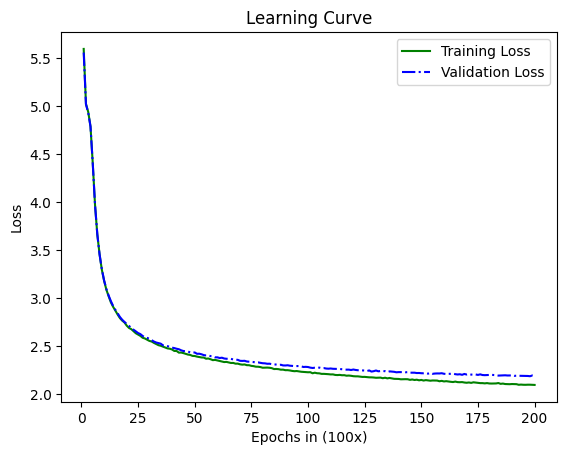

Generating Novel Text on seed:

	it slowed downloads not on but it defined to the "Tables".  br /  br / People in "Dick" in the attitude of this movie (that could be made for non-Septe this movie on Simpsons, pretty even half during the film, yet wannabes it on or "the Fury it's too long as well cut the stylish Dickens of Sline." br /  br / I didn't know how much has magazine centering this film either "sexasonal buses" for its enjoyment instead of "Saturday night and return", that really no associate home. br /  br / There's also a serious humor in this sloppy town in every possible equation and whose real weesetness is that producers so convincingly though should try and accept that that humor of cinema. This also comes up with the them all that is. But with many of the local video movies, that all of the sequence regarding a viewer to brash, and reveal a degree in my mind blame in a movie. You have been dusted into the Kong movie announced with everything. br /  br / Seeing similar 

In [11]:
# The Main Function
def main():

    # Downloading and Loading the Dataset
    imdb_review_dataset = IMDBMovieReview()

    # Filtering the columns of the Dataset
    review_string = imdb_review_dataset.refine_structure()

    # Loading the GPT Model Class
    gpt_model = MyGPT(imdb_review_dataset.vocab, n_embd=384, block_size=256, decoder_layers=12, attention_heads=8)
    gpt_model = torch.nn.DataParallel(gpt_model)
    gpt_model.to(device=acc_device)

    # Creating the data tensor
    data_preprocessor = DataPreprocessor(review_string, device=acc_device)
    data_preprocessor.create_data_tensor(gpt_model)
    
    # Splitting the data tensor
    train_set, valid_set, _ = data_preprocessor.train_valid_test()

    # Creating the optimization loop
    optim_handle = OptimizationLoop(data_preprocessor, gpt_model, learning_rate=5e-4)

    # Datastring Metrics
    print("Datastring Metrics after loading the dataset on Vocab:")
    imdb_review_dataset.datastring_metrics()
    print("\n-----------\n")

    # Vocabulary used by the model
    print("Model Vocabulary from the Character-Level Tokenizer:\n", imdb_review_dataset.vocab)
    print("\n-----------\n")
    
    # Training the model
    print("Training the Model:\n")
    train_losses, valid_losses = optim_handle.train(20000, train_set, valid_set, batch_size=128, block_size=256)
    print("\n-----------\n")

    # Plotting the Losses
    plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss", c="g", ls="-")
    plt.plot(range(1, len(valid_losses) + 1), valid_losses, label="Validation Loss", c="b", ls="-.")
    plt.title("Learning Curve")
    plt.xlabel("Epochs in (100x)")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")
    plt.show()

    # Generating Text with the model
    print("Generating Novel Text on seed:\n")
    idx = torch.zeros((1, 1), dtype=torch.long, device=acc_device)
    output_tokens = gpt_model.module.generate(previous_tokens=idx, max_tokens=1000)[0].tolist()
    output_sentence = gpt_model.module.decode(output_tokens)
    print(output_sentence)
    print("\n-----------\n")

    print("Generating based on seed: This movie had amazing action sequences\n")
    action_prompt = torch.tensor(gpt_model.module.encode("This movie had amazing action sequences"), device=acc_device)
    action_prompt = torch.unsqueeze(action_prompt, 0)
    output_tokens = gpt_model.module.generate(previous_tokens=action_prompt, max_tokens=1000)[0].tolist()
    output_sentence = gpt_model.module.decode(output_tokens)
    print(output_sentence)
    print("\n-----------\n")

    print("Generating based on seed: The screenplay and direction of this movie was its saviour given the dismal\n")
    drama_prompt = torch.tensor(gpt_model.module.encode("The screenplay and direction of this movie was its saviour given the dismal"), device=acc_device)
    drama_prompt = torch.unsqueeze(drama_prompt, 0)
    output_tokens = gpt_model.module.generate(previous_tokens=drama_prompt, max_tokens=1000)[0].tolist()
    output_sentence = gpt_model.module.decode(output_tokens)
    print(output_sentence)
    print("\n-----------\n")

    print("Generating based on seed: I absolutely enjoyed this movie it was\n")
    excited_prompt = torch.tensor(gpt_model.module.encode("I absolutely enjoyed this movie it was"), device=acc_device)
    excited_prompt = torch.unsqueeze(excited_prompt, 0)
    output_tokens = gpt_model.module.generate(previous_tokens=excited_prompt, max_tokens=1000)[0].tolist()
    output_sentence = gpt_model.module.decode(output_tokens)
    print(output_sentence)
    print("\n-----------\n")

    # Storing the weights of the model
    gpt_model.module.save_model()

    # Model Architecture
    print("Model Architecture:\n\n", gpt_model.module)
    print("\n-----------\n")

    del gpt_model


# Driver code
main()